#Import Packages

In [1]:
from __future__ import print_function
import tensorflow
import json
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from keras import models
from keras.utils import plot_model
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load data and create a subset with size of 5000 data(with same number for each class)

In [3]:
weight_decay = 0.0005
batch_size = 50

#Class for define model and important methods for data preproccesing and train model

In [99]:
class cifar10vgg:
    def __init__(self, train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32, 32, 3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('/content/drive/MyDrive/cifar10vgg.h5')
    def custom_loss(y_actual, y_pred):
        custom_loss = K.square(y_actual - y_pred)
        return custom_loss

    def build_model(self):

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                            input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())

        model.add(Conv2D(256 , (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512 , (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())

        model.add(Conv2D(512 , (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512 , (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())

        model.add(Conv2D(512 , (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(4096 ,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        
        model.add(Dense(4096 ,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        # model.add(BatchNormalization())
        
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        return model

    def normalize(self, x_train, x_test):
        mean = np.mean(x_train,axis=(0,1,2,3))
        std = np.std(x_train, axis=(0, 1, 2, 3))
        x_train = (x_train-mean)/(std+1e-7)
        x_test = (x_test-mean)/(std+1e-7)
        return x_train, x_test

    def normalize_production(self, x):
        mean = 120.707
        std = 64.15
        x = (x-mean)/(std+1e-7)
        return x

    def predict(self, x, normalize=True, batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x, batch_size)

    def train(self, model):
        batch_size = 128
        maxepoches = 20
        learning_rate = 0.001
        lr_decay = 1e-6
        lr_drop = 20
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')

        x_train_s= []
        y_train_s= []
        for i in range(10):
          c = 0
          for j in range(len(y_train)):
            if c == 500:
              break
            if y_train[j][0] == i:
              x_train_s.append(x_train[j])
              y_train_s.append(y_train[j][0])
              c += 1

        x_train, y_train = shuffle(x_train_s, y_train_s)
        x_train = np.array(x_train)
        x_train, x_test = self.normalize(x_train, x_test)
        y_train = np.array(y_train)
        y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
        y_test = tensorflow.keras.utils.to_categorical(y_test, 10)        
        x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.2,shuffle = True,  random_state=42)
    
        def lr_scheduler(self, epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = tensorflow.keras.callbacks.LearningRateScheduler(lr_scheduler)

        # data augmentation
        datagen = ImageDataGenerator(
            featurewise_std_normalization=False,
            samplewise_std_normalization=False)
        
        datagen.fit(x_train)

        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        historytemp = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                epochs=maxepoches,
                                validation_data=(x_valid, y_valid),
                                callbacks=[reduce_lr],
                                verbose=1)

        history_dict = historytemp.history

        # Save the model
        print("batchsize :")
        print(history_dict)
        model.save_weights('/content/drive/MyDrive/cifar10vgg.h5')
        model.save("/content/drive/MyDrive/vifar.h5")
        return model

#Train Model

In [100]:
mymodel = cifar10vgg()

Epoch 1/20
31/31 [==============================] - 3s 62ms/step - loss: 5.9888 - accuracy: 0.1178 - val_loss: 5.9996 - val_accuracy: 0.1360 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 2s 52ms/step - loss: 5.9407 - accuracy: 0.1650 - val_loss: 5.9926 - val_accuracy: 0.2590 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 2s 51ms/step - loss: 5.8515 - accuracy: 0.2701 - val_loss: 5.9752 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 2s 52ms/step - loss: 5.7147 - accuracy: 0.3153 - val_loss: 5.9405 - val_accuracy: 0.2780 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 2s 52ms/step - loss: 5.5891 - accuracy: 0.3332 - val_loss: 5.8996 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 2s 52ms/step - loss: 5.4898 - accuracy: 0.3585 - val_loss: 5.8567 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 2s 52ms/step - loss: 5.3

#Plot Model

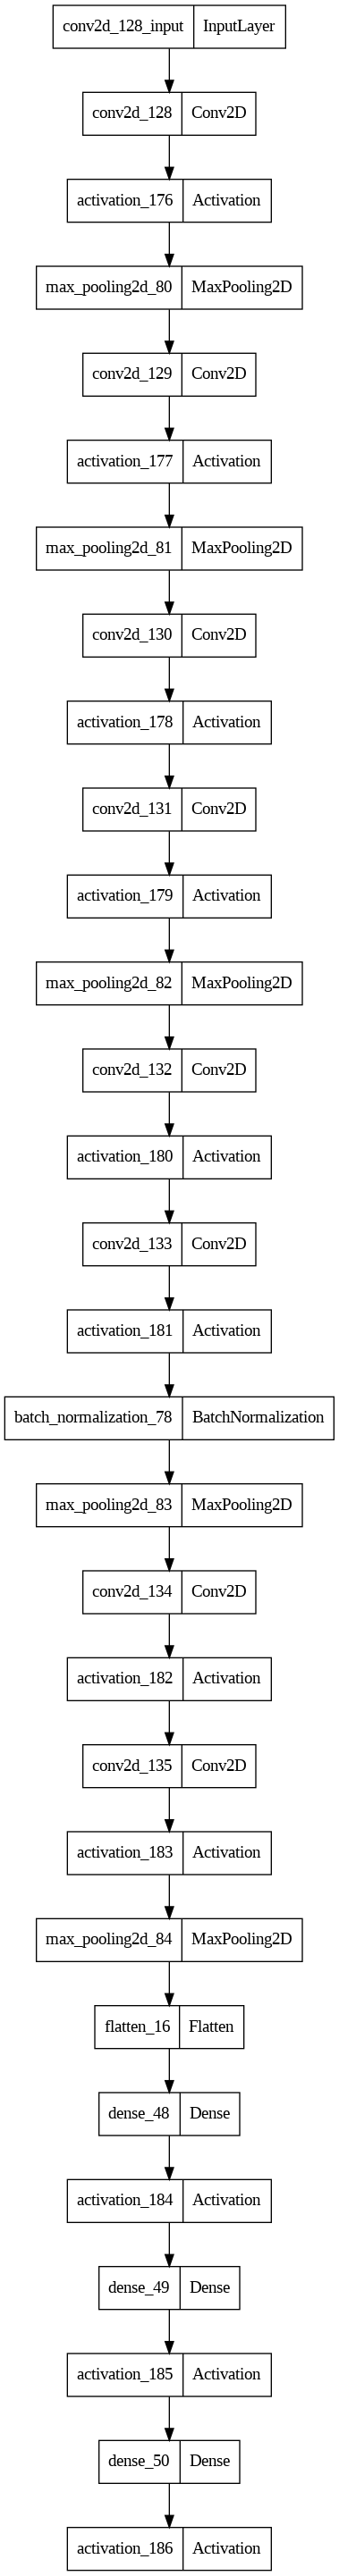

In [101]:
plot_model(mymodel.model)

In [102]:
mymodel.model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 activation_176 (Activation)  (None, 32, 32, 64)       0         
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 activation_177 (Activation)  (None, 16, 16, 128)      0         
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                

#Plot accuracy and loss of train and validation

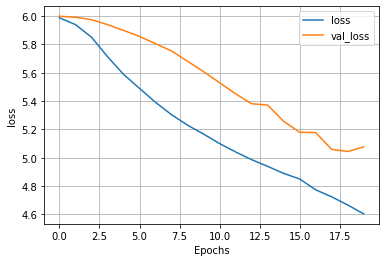

In [103]:
plt.plot(mymodel.model.history.history['loss'],label = 'loss')
plt.plot(mymodel.model.history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

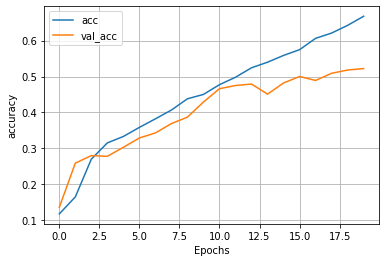

In [104]:
plt.plot(mymodel.model.history.history['accuracy'],label = 'acc')
plt.plot(mymodel.model.history.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()

#loss and accuracy of test data

In [105]:
test_loss, test_accuracy = mymodel.model.evaluate(x_test, y_test, verbose=0)
print('Test_loss:', test_loss)
print('Test_accuracy:', test_accuracy)

Test_loss: 5.06718635559082
Test_accuracy: 0.5023000240325928


#Load trained model

In [106]:
vgg_model = models.load_model("/content/drive/MyDrive/vifar.h5")

In [107]:
vgg_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 activation_176 (Activation)  (None, 32, 32, 64)       0         
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 activation_177 (Activation)  (None, 16, 16, 128)      0         
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                

#Compte CSI for Convolutional layers

In [108]:
from sklearn.utils import shuffle
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train_s= []
y_train_s= []
for i in range(10):
  c = 0
  for j in range(len(y_train)):
    if c == 100:
      break
    if y_train[j][0] == i:
      x_train_s.append(x_train[j])
      y_train_s.append(y_train[j][0])
      c += 1

x_train = np.array(x_train_s)
y_train = np.array(y_train_s)
y_train = tensorflow.keras.utils.to_categorical(y_train, 10)
y_test = tensorflow.keras.utils.to_categorical(y_test, 10)

In [109]:
csi_history = []
for idx in range(24):
  if idx == 2 or idx == 5 or idx == 7 or idx == 10 or idx == 12 or idx == 16 or idx == 18 or idx == 21:
    index_layer = idx
    # index_layer = 4*(index_layer1 + 1) - 1
    out_shape = vgg_model.layers[index_layer].output.type_spec.shape
    out_dim = out_shape[1] * out_shape[2] * out_shape[3]

    embed_model = models.Model(inputs=vgg_model.input, outputs=vgg_model.layers[index_layer].output)

    # normalize the data with normalize function from cifar10vgg class
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)

    pred_out = embed_model.predict(x_train)

    pred_out = pred_out.reshape(len(y_train), out_dim, 1)

    mu_list = []

    # calculate means
    for i in range(0, 10):
        class_mean = np.mean(pred_out[100*i:100*(i+1)], axis=0)
        mu_list.append(class_mean)

    mu_list = np.array(mu_list)

    # center based SI calculation
    counter = 0
    for i in range(1000):
        dis_list = []
        for j in range(0, 10):
          dis_list.append(cdist(pred_out[i].T, mu_list[j].T)[0])

        if np.argmin(np.array(np.reshape(dis_list,(10,)))) == np.argmax(y_train[i]):
            counter += 1

    csi = (counter/len(y_train))*100

    csi_history.append(csi)

    print(f"CSI {index_layer} : {csi:3f} %")

32/32 [==============================] - 0s 2ms/step
CSI 2 : 33.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 5 : 38.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 7 : 41.100000 %
32/32 [==============================] - 0s 2ms/step
CSI 10 : 41.100000 %
32/32 [==============================] - 0s 4ms/step
CSI 12 : 43.600000 %
32/32 [==============================] - 0s 4ms/step
CSI 16 : 48.500000 %
32/32 [==============================] - 0s 4ms/step
CSI 18 : 50.000000 %
32/32 [==============================] - 0s 4ms/step
CSI 21 : 48.300000 %


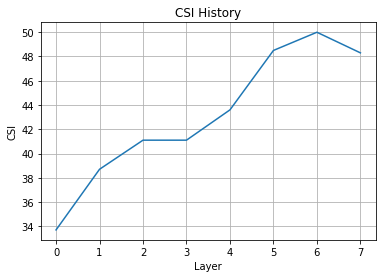

In [110]:
plt.plot(csi_history)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI History')
plt.grid()
plt.show()


In [111]:
csi_history = []
for index_layer in range(22):

    # if idx == 2 or idx == 5 or idx == 7 or idx == 10 or idx == 12 or idx == 15 or idx == 17 or idx == 20:
    #   index_layer = idx
      out_shape = vgg_model.layers[index_layer].output.type_spec.shape
      out_dim = out_shape[1] * out_shape[2] * out_shape[3]

      embed_model = models.Model(inputs=vgg_model.input, outputs=vgg_model.layers[index_layer].output)

      # normalize the data with normalize function from cifar10vgg class
      mean = np.mean(x_train,axis=(0,1,2,3))
      std = np.std(x_train, axis=(0, 1, 2, 3))
      x_train = (x_train-mean)/(std+1e-7)
      x_test = (x_test-mean)/(std+1e-7)

      pred_out = embed_model.predict(x_train)

      pred_out = pred_out.reshape(len(y_train), out_dim, 1)

      # list of pred_out and y_test
      # data = list(zip(pred_out, y_train))

      # sort data based on y_test
      # data.sort(key=lambda x: x[1][0])


      mu_list = []

      # calculate means
      for i in range(0, 10):
          class_mean = np.mean(pred_out[100*i:100*(i+1)], axis=0)
          mu_list.append(class_mean)

      mu_list = np.array(mu_list)

      # center based SI calculation
      counter = 0
      for i in range(1000):
          dis_list = []
          for j in range(0, 10):
            dis_list.append(cdist(pred_out[i].T, mu_list[j].T)[0])
          if np.argmin(np.array(np.reshape(dis_list,(10,)))) == np.argmax(y_train[i]):
              counter += 1

      csi = (counter/len(y_train))*100

      csi_history.append(csi)

      print(f"CSI {index_layer} : {csi:3f} %")

32/32 [==============================] - 0s 1ms/step
CSI 0 : 30.700000 %
32/32 [==============================] - 0s 1ms/step
CSI 1 : 32.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 2 : 33.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 3 : 36.400000 %
32/32 [==============================] - 0s 2ms/step
CSI 4 : 38.000000 %
32/32 [==============================] - 0s 2ms/step
CSI 5 : 38.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 6 : 40.100000 %
32/32 [==============================] - 0s 2ms/step
CSI 7 : 41.100000 %
32/32 [==============================] - 0s 2ms/step
CSI 8 : 42.700000 %
32/32 [==============================] - 0s 2ms/step
CSI 9 : 42.500000 %
32/32 [==============================] - 0s 2ms/step
CSI 10 : 41.100000 %
32/32 [==============================] - 0s 3ms/step
CSI 11 : 42.900000 %
32/32 [==============================] - 0s 3ms/step
CSI 12 : 43.600000 %
32/32 [==============================] - 0s 4ms/

# Plot the CSI history


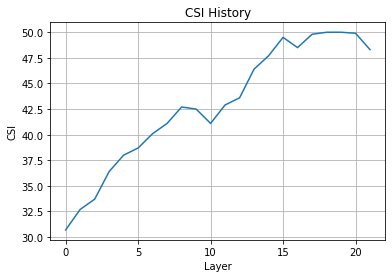

In [112]:
plt.plot(csi_history)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI History')
plt.grid()
plt.show()
